## This is my attempt to use martin's data creation technique and then put it in Siamene Network using Fast AI. I am using following links for this:
https://www.kaggle.com/martinpiotte/whale-recognition-model-with-score-0-78563/output
https://github.com/radekosmulski/whale/blob/master/siamese_network_prototype.ipynb

In [1]:
# Suppress annoying stderr output when importing keras.
import sys
import platform
old_stderr = sys.stderr
sys.stderr = open('/dev/null' if platform.system() != 'Windows' else 'nul', 'w')

sys.stderr = old_stderr

import random
from scipy.ndimage import affine_transform

import pickle
import numpy as np
from math import sqrt

# Determise the size of each image
from os.path import isfile
from PIL import Image as pil_image
from tqdm import tqdm_notebook

from pandas import read_csv
import pandas as pd
from pathlib import Path

In [2]:
root_path = Path('../input')
train_path = root_path/'train_224'
test_path = root_path/'test_224'

In [3]:
name = f'siamese_resnet50_224'

#arch = models.resnet50
SZ = 224
BS = 24
NUM_WORKERS = 6
SEED=0

In [4]:
df = pd.read_csv(root_path/'train.csv')
im_count = df[df.Id != 'new_whale'].Id.value_counts()
im_count.name = 'sighting_count'
df = df.join(im_count, on='Id')

For training data, we are taking all the images except for the category - New Whale

In [5]:
new_df = df[df['Id']!= 'new_whale']
#new_df = new_df[new_df['sighting_count']>1]

print('shape of data for training ',new_df.shape)
new_df.drop(columns = ['sighting_count'] , inplace=True)
new_df.head(2)

shape of data for training  (15697, 3)


/home/wb/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a


In [6]:
new_df.reset_index(inplace=True)
new_df.drop(columns='index' , inplace=True)
new_df.tail(3)

/home/wb/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,Image,Id
15694,fff7faf61.jpg,w_9cf0388
15695,fff9002e0.jpg,w_bd1c3d5
15696,fffcde6fe.jpg,w_9f30885


In [7]:
new_df.to_records()

rec.array([(    0, '0000e88ab.jpg', 'w_f48451c'),
           (    1, '0001f9222.jpg', 'w_c3d896a'),
           (    2, '00029d126.jpg', 'w_20df2c5'), ...,
           (15694, 'fff7faf61.jpg', 'w_9cf0388'),
           (15695, 'fff9002e0.jpg', 'w_bd1c3d5'),
           (15696, 'fffcde6fe.jpg', 'w_9f30885')],
          dtype=[('index', '<i8'), ('Image', 'O'), ('Id', 'O')])

In [8]:
"""
The data set we are using for training contains all images except of new whales.
we don't require creating phase values for this  datasets , as duplicate images are very few.
i am using index present in train.csv as the phase value as we can use it for indexing very easily 
"""

tagged = dict([(p,w) for _,p,w in new_df.to_records()])
h2ps = dict([(idx , p ) for   idx,p,w in new_df.to_records()])
p2h   = dict([(p , idx) for idx , p , w in new_df.to_records()])
h2p = h2ps.copy()
join = tagged.copy()

In [9]:
def expand_path(p):
    if isfile(train_path/p): 
        return train_path/p
    if isfile(test_path/p): 
        return test_path/p
    return p

p2size = {}
for p in tqdm_notebook(join):
    size      = pil_image.open(expand_path(p)).size
    p2size[p] = size
len(p2size), list(p2size.items())[:5]

(15697,
 [('0000e88ab.jpg', (224, 224)),
  ('0001f9222.jpg', (224, 224)),
  ('00029d126.jpg', (224, 224)),
  ('000a6daec.jpg', (224, 224)),
  ('0016b897a.jpg', (224, 224))])

In [10]:
## phase value for all categories except new whale
h2ws = {}
new_whale = 'new_whale'
for p,w in tagged.items():
    if w != new_whale: # Use only identified whales
        h = p2h[p]
        if h not in h2ws: h2ws[h] = []
        if w not in h2ws[h]: h2ws[h].append(w)
for h,ws in h2ws.items():
    if len(ws) > 1:
        h2ws[h] = sorted(ws)
len(h2ws)

15697

In [11]:
## for each whale category, observe the associated phase values , 
##store all whale categories even the categories with just one image ( this is  different from martin's approach)

w2hs = {}
for h,ws in h2ws.items():
    if len(ws) == 1: # Use only unambiguous pictures

        w = ws[0]
        if w not in w2hs: w2hs[w] = []
        if h not in w2hs[w]: w2hs[w].append(h)
for w,hs in w2hs.items():
    #if len(hs) > 1:
        w2hs[w] = sorted(hs)
len(w2hs)

5004

In [12]:
len(h2ws)

15697

In [13]:
def read_raw_image(p):
    img = pil_image.open(expand_path(p))
    return img


import matplotlib.pyplot as plt


In [14]:
train = [] # A list of  indices of images to be used in training data.
for hs in w2hs.values():
    if len(hs) >= 1:
        train += hs
random.shuffle(train)
train_set = set(train)

In [15]:
## we have whales categories with phases(images) more than 1. shuffle the phase values now.
w2ts = {} #Associate the image index from train to each whale id.
for w,hs in w2hs.items():
    for h in hs:
        if h in train_set:
            if w not in w2ts: w2ts[w] = []
            if h not in w2ts[w]: w2ts[w].append(h)
for w,ts in w2ts.items(): w2ts[w] = np.array(ts)
## then again for each whale categories see how many images you have , 
## you are working with 5004 whale categories and 15697 images 
    
    
t2i = {} # The position in train of each training image id
for i,t in enumerate(train): t2i[t] = i

len(train),len(w2ts)

(15697, 5004)

In [16]:
# from keras.utils import Sequence
# import keras

from IPython.core.debugger import set_trace
import random
#from keras import backend as K

try:
    from lapjv import lapjv
    segment = False
except ImportError:
    print('Module lap not found, emulating with much slower scipy.optimize.linear_sum_assignment')
    segment = True
    from scipy.optimize import linear_sum_assignment


Import functions from fast ai library

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import accuracy_thresh
from fastai.basic_data import *
from torch.utils.data import DataLoader, Dataset
from torch import nn
from fastai.callbacks.hooks import num_features_model, model_sizes
from fastai.layers import BCEWithLogitsFlat
from fastai.basic_train import Learner
from skimage.util import montage
import pandas as pd
from torch import optim
import re

from utils import *

from IPython.core.debugger import set_trace
from functional import seq


In [18]:

fn2label = {row[1].Image: row[1].Id for row in df.iterrows()}  #new_
path2fn = lambda path: re.search('\w*\.jpg$', path).group(0)


Creating dataset for all the training images. Because of some reason , i am not able to create validation set as well ( produces error while indexing from match and unmatch matrices. If someone is able to find the work arounf the help will be appreciated

In [19]:
classes = df.Id.unique()
data = (
    ImageItemList  ##df[(df.Id != 'new_whale') & (df.sighting_count >1)]
        .from_df( df[(df.Id != 'new_whale')], train_path, cols=['Image'])
        .no_split()##split_by_valid_func(lambda path: path2fn(path) in val_fns) 
        .label_from_func(lambda path: fn2label[path2fn(path)] ,  classes=classes)
        .add_test(ImageItemList.from_folder(test_path))
        .transform(get_transforms(do_flip=False), size=SZ, resize_method=ResizeMethod.SQUISH))

In [20]:
print(len(train))
print(len(data.train.x))
print(len(data.valid.x))

15697
15697
1


In [21]:
from IPython.core.debugger import set_trace
import random

# First try to use lapjv Linear Assignment Problem solver as it is much faster.
# At the time I am writing this, kaggle kernel with custom package fail to commit.
# scipy can be used as a fallback, but it is too slow to run this kernel under the time limit
# As a workaround, use scipy with data partitioning.
# Because algorithm is O(n^3), small partitions are much faster, but not what produced the submitted solution
try:
    from lapjv import lapjv
    segment = False
except ImportError:
    print('Module lap not found, emulating with much slower scipy.optimize.linear_sum_assignment')
    segment = True
    from scipy.optimize import linear_sum_assignment


TwoImDataset creation is the part where I am trying to replicate 'TrainingData Class' from https://www.kaggle.com/martinpiotte/whale-recognition-model-with-score-0-78563/output
For whale categories having just one images in training data , matching pair -  same image pair (A,A) . For other categories it creates a de arrangement.  

In [22]:
np.random.random()

0.913699324280563

In [23]:
import pdb
def is_even(num): return num % 2 == 0

class TwoImDataset(Dataset):
    def __init__(self, ds, score, steps = 1000):
        self.ds = ds
        self.whale_ids = ds.y.items
        self.steps =1000
        self.score  = -score
        for ts in w2ts.values():
            idxs =  ts.copy() #[t2i[t] for t in ts]
            #idxs = [i for i in  idxs if i <score.shape[0]]
            for i in idxs:
                for j in idxs:
                    self.score[i,j] = 10000.0   # Set a large value for matching
        self.epsilon = 1.0
        self.on_epoch_end()
        
    def set_epsilon(self, epsilon=1.0):
        self.epsilon = epsilon
        
    def __len__(self):
        return 2 * len(self.ds)

    def __getitem__(self, idx):
        prob = np.random.random()
        choice = idx % 2 == 0
        if choice:
            idx //=2
        else:
            idx = (idx - 1) // 2
        
        if prob < self.epsilon: 
            return self.sample_random(idx, choice)
        else:
            return self.sample_policy(idx, choice)
                
    def sample_random(self, idx, choice):
        if choice:
            return self.sample_same(idx)
        else: return self.sample_different(idx)

    def sample_same(self, idx):
        whale_id = self.whale_ids[idx]        
        candidates = list(np.where(self.whale_ids == whale_id)[0])
        candidates.remove(idx) # dropping our current whale - we don't want to compare against an identical image!
        
        if len(candidates) == 0: # oops, there is only a single whale with this id in the dataset
            return self.sample_different(idx)
        
        np.random.shuffle(candidates)
        return self.construct_example(self.ds[idx][0], self.ds[candidates[0]][0], 1)
    
    def sample_different(self, idx):
        whale_id = self.whale_ids[idx]
        candidates = list(np.where(self.whale_ids != whale_id)[0])
        np.random.shuffle(candidates)
        return self.construct_example(self.ds[idx][0], self.ds[candidates[0]][0], 0)
  
    def sample_policy(self, idx , tag):
        #set_trace()
        if tag==0:
            first_image_id =  self.match[idx][0]
            second_image_id = self.match[idx][1]
            #if first_image_id < len(self.ds) and second_image_id< len(self.ds):         
            return self.construct_example(self.ds[first_image_id][0], self.ds[second_image_id][0], 1)
        else:
            first_image_id =  self.unmatch[idx][0]
            second_image_id = self.unmatch[idx][1]     
            return self.construct_example(self.ds[first_image_id][0], self.ds[second_image_id][0], 0)
  
    def on_epoch_end(self):
        if self.steps <= 0: return # Skip this on the last epoch.
        self.steps     -= 1
        self.match      = []
        self.unmatch    = []
        if segment:
            tmp   = []
            batch = 512
            for start in range(0, score.shape[0], batch):
                end = min(score.shape[0], start + batch)
                _, x = linear_sum_assignment(self.score[start:end, start:end])
                tmp.append(x + start)
            x = np.concatenate(tmp)
        else:
            #print('using lapjv')
            x,_,_ = lapjv(self.score) # Solve the linear assignment problem
        y = np.arange(len(x),dtype=np.int32)

        # Compute a derangement for matching whales
        for ts in w2ts.values():
            d = ts.copy()
            if (len(d)==1):
                for ab in zip(ts,d): self.match.append(ab)
            else:                
                while True:
                    random.shuffle(d)
                    if not np.any(ts == d): break
                for ab in zip(ts,d): self.match.append(ab)

        # Construct unmatched whale pairs from the LAP solution.
        for i,j in zip(x,y):
            if i == j:
                print(self.score)
                print(x)
                print(y)
                print(i,j)
            assert i != j
            self.unmatch.append((train[i],train[j]))

        # Force a different choice for an eventual next epoch.
        self.score[x,y] = 10000.0
        self.score[y,x] = 10000.0
        random.shuffle(self.match)
        random.shuffle(self.unmatch)
        print('end of epoch, math',self.match[0][0])
        print('end of epoch, unmatch',self.unmatch[0][0])
        
        print(len(self.match), len(train), len(self.unmatch), len(train))
        #assert len(self.match) == len(train) and len(self.unmatch) == len(train)
    
    def construct_example(self, im_A, im_B, class_idx):
        return [im_A, im_B], class_idx

In [24]:
"""
Create a 2D score matrix of size of training data
"""

score = np.random.random_sample(size=(len(train),len(train)))

train_dl = DataLoader(
    TwoImDataset(data.train , score),
    batch_size=BS,
    shuffle=True,
    num_workers=NUM_WORKERS
)


end of epoch, math 4089
end of epoch, unmatch 7417
15697 15697 15697 15697


In [25]:
def normalize_batch(batch):
    stat_tensors = [torch.tensor(l).cuda() for l in imagenet_stats]
    return [normalize(batch[0][0], *stat_tensors), normalize(batch[0][1], *stat_tensors)], batch[1]

In [26]:
data_bunch = ImageDataBunch(train_dl , train_dl) ##, valid_dl
data_bunch.add_tfm(normalize_batch)

In [27]:
"""
The netowrk architecture is also inspired from Martin's notebook (part after we extract features for two image pairs)
"""
class SiameseNetwork(nn.Module):
    def __init__(self, arch=models.resnet50):
        super().__init__() 
        
        self.cnn = create_body(arch)
        self.head = nn.Linear(num_features_model(self.cnn), 1)  #
        
        self.conv1 = nn.Conv2d(1 , 32 , kernel_size= (1 , 4) , padding = 0 ,stride=1)
        self.conv2 = nn.Conv2d( 1 , 1 , kernel_size = (32 ,1 ) , padding = 0  , stride=1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, im_A, im_B):
        x1, x2 = seq(im_A, im_B).map(self.cnn).map(self.process_features)
        d1 = self.calculate_distance(x1, x2)
        d2 = (x1 + x2)
        d3 = (x1*x2)
        d4 = (x1-x2)*(x1 - x2)
        concat_layer = torch.cat([d1 ,d2,d3, d4]  ,dim = 1)
        concat_layer = concat_layer.view( - 1, 1, num_features_model(self.cnn) , 4)   ## no of channels is second dimension
        concat_layer  = F.relu(self.conv1(concat_layer))
        concat_layer = concat_layer.view(-1 ,1,32, num_features_model(self.cnn))
        concat_layer = F.relu(self.conv2(concat_layer))
        concat_layer_fn = concat_layer.view(-1 ,num_features_model(self.cnn))
        dropt = self.dropout(concat_layer_fn)
        out = self.head(dropt)
        return out
    
    def process_features(self, x): 
        y = x.reshape(*x.shape[:2], -1)
        return x.reshape(*x.shape[:2], -1).max(-1)[0]
    def calculate_distance(self, x1, x2): return (x1 - x2).abs_()

In [28]:
learn = Learner(data_bunch, SiameseNetwork(), 
                loss_func=BCEWithLogitsFlat(), 
                wd=0.01,
                metrics=[lambda preds, targs: accuracy_thresh(preds.squeeze(), targs, sigmoid=False)])

In [29]:
def linear_schedule(step, pars):
    "Linearly output value, end_step must greater than start_step"
    start_value = pars[0]
    end_value = pars[1]
    start_step = pars[2]
    end_step = pars[3]
    assert start_step <= end_step

    if step < start_step:
        return start_value
    elif step >= end_step:
        return end_value
    return start_value - (step - start_step) * (start_value - end_value) / (end_step - start_step)


In [30]:
linear_decay = partial(linear_schedule, pars=(1.0, 0.05, 2, 12))
linear_decay(0)

1.0

In [31]:
class DataloaderCallback(fastai.callbacks.tracker.TrackerCallback):
    def __init__(self, learn, schedule_pars=(1.0, 0.05, 0, 10)):
        super().__init__(learn)
        self.schedule = partial(linear_schedule, pars=schedule_pars)
        
    #def on_batch_end(self, last_loss, epoch, num_batch, **kwargs: Any) -> None:
    def on_epoch_begin(self, epoch, **kwargs: Any) -> None:
        epsilon = self.schedule(epoch)
        self.learn.data.train_ds.set_epsilon(epsilon)
        self.learn.data.train_ds.on_epoch_end()



In [32]:
learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.head])
learn.freeze_to(-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


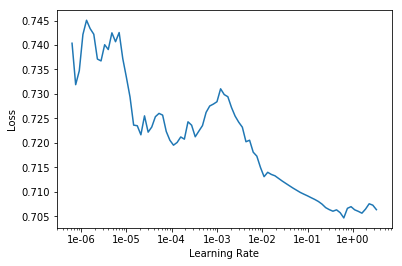

In [33]:
learn.lr_find()
learn.recorder.plot()

In [34]:
cb_dl = DataloaderCallback(learn, schedule_pars=(1.0, 0.05, 0, 10))
cbs = [cb_dl]

In [35]:
learn.fit_one_cycle(4 , 1e-3, callbacks=cbs)

epoch,train_loss,valid_loss,
1,0.322401,0.303130,0.868701
2,0.265975,0.265628,0.889756
3,0.205162,0.190742,0.917213
4,0.173131,0.177001,0.924030


end of epoch, math 11484
end of epoch, unmatch 5302
15697 15697 15697 15697
end of epoch, math 2799
end of epoch, unmatch 8392
15697 15697 15697 15697
end of epoch, math 9653
end of epoch, unmatch 4998
15697 15697 15697 15697
end of epoch, math 136
end of epoch, unmatch 613
15697 15697 15697 15697


In [36]:
learn.unfreeze()

In [37]:
max_lr = 3e-4
lrs = [max_lr/100, max_lr/10, max_lr]

In [ ]:
learn.fit_one_cycle(10, lrs, callbacks=cbs)
learn.save(f'{name}-stage2_unfz')

epoch,train_loss,valid_loss,
1,0.179778,0.168280,0.929445
2,0.194567,0.169452,0.920112
3,0.166713,0.162802,0.927375


end of epoch, math 12786
end of epoch, unmatch 2898
15697 15697 15697 15697
end of epoch, math 10130
end of epoch, unmatch 15617
15697 15697 15697 15697
end of epoch, math 13537
end of epoch, unmatch 6009
15697 15697 15697 15697
end of epoch, math 15049
end of epoch, unmatch 14635
15697 15697 15697 15697


In [ ]:
learn.load(f'{name}-stage2_unfz');

In [ ]:
learn.recorder.plot_losses()

In [ ]:
cb_dl = DataloaderCallback(learn, schedule_pars=(0.05, 0.01, 0, 10))
cbs = [cb_dl]

In [ ]:
learn.fit_one_cycle(10, lrs, callbacks=cbs)
learn.save(f'{name}-stage3_unfz')


In [ ]:
learn.fit_one_cycle(10, lrs, callbacks=cbs)
learn.save(f'{name}-stage4_unfz')


In [ ]:
learn.fit_one_cycle(10, lrs, callbacks=cbs)
learn.save(f'{name}-stage5_unfz')


In [ ]:
learn.fit_one_cycle(10, lrs, callbacks=cbs)
learn.save(f'{name}-stage6_unfz')


In [ ]:
learn.fit_one_cycle(10, lrs, callbacks=cbs)
learn.save(f'{name}-stage7_unfz')


In [ ]:
learn.fit_one_cycle(10, lrs, callbacks=cbs)
learn.save(f'{name}-stage8_unfz')


In [ ]:
learn.fit_one_cycle(10, lrs, callbacks=cbs)
learn.save(f'{name}-stage9_unfz')


In [ ]:
learn.fit_one_cycle(10, lrs, callbacks=cbs)
learn.save(f'{name}-stage10_unfz')


In [ ]:
learn.load(f'{name}-stage3_unfz')

In [ ]:
new_whale_fns = set(df[df['Id']=='new_whale'].sample(frac = 1).Image.iloc[:1000])
#new_whale_fns

In [ ]:
val_fns = set(df[df.sighting_count == 2].Image)
print(len(val_fns) + len(new_whale_fns))

classes = df.Id.unique()

df = df.drop(columns = ['sighting_count'])
df.head(2)

In [ ]:

data = (
    ImageItemList
        .from_df(df, train_path, cols=['Image'])
        .split_by_valid_func(lambda path: path2fn(path) in val_fns) ##.union(new_whale_fns)
        .label_from_func(lambda path: fn2label[path2fn(path)], classes=classes)
        .add_test(ImageItemList.from_folder(test_path))
        .transform(get_transforms(do_flip=False), size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path=root_path)
        .normalize(imagenet_stats)
)

In [ ]:
%%time
targs = []
feats = []
learn.model.eval()
for ims, ts in data.valid_dl:
    feats.append(learn.model.process_features(learn.model.cnn(ims)).detach().cpu())  ##
    targs.append(ts)

feats = torch.cat(feats)
print(feats.shape)

In [ ]:
%%time
sims = []
for feat in feats:
    x1 = feats#.copy()
    x2 = feat.unsqueeze(0).repeat(2570 ,1)
    d1 = learn.model.calculate_distance(x1 , x2)
    d2 = (x1 + x2)
    d3 = (x1*x2)
    d4 = (x1-x2)*(x1 - x2)
    concat_layer = torch.cat([d1 ,d2,d3, d4]  ,dim = 1)
    concat_layer = concat_layer.view( - 1, 1, num_features_model(learn.model.cnn) , 4)   ## no of channels is second dimension
    concat_layer  = F.relu(learn.model.conv1(concat_layer.cuda()))
    concat_layer = concat_layer.view(-1 ,1,32, num_features_model(learn.model.cnn)  )
    concat_layer = F.relu(learn.model.conv2(concat_layer))
    concat_layer_fn = concat_layer.view(-1 ,num_features_model(learn.model.cnn) )
    #out = learn.model.head(concat_layer_fn)
    predicted_similarity = learn.model.head(concat_layer_fn).sigmoid_()  #.cuda()
    sims.append(predicted_similarity.squeeze().detach().cpu())

    


In [ ]:
len(sims[0])

In [ ]:
new_whale_idx = np.where(classes == 'new_whale')[0][0]
new_whale_idx

In [ ]:
top_5s = []
for i, sim in enumerate(sims):
    idxs = sim.argsort(descending=True)
    probs = sim[idxs]
    top_5 = []
    for j, p in zip(idxs, probs):
        if len(top_5) == 5: break
        if j == i: continue   
        predicted_class = data.valid_ds.y.items[j]
        """
        we dont want to predict new whale for validation data 
        """
        if predicted_class == new_whale_idx: continue
        if predicted_class not in top_5: top_5.append(predicted_class)
    top_5s.append(top_5)
    
## top 5 contains 5 best predicted classes ,w ith indices from classes dictionary

In [ ]:
top_5s[:5]

In [ ]:
"""
mapk of validation data set without having new whales in predictions. 
"""
mapk(data.valid_ds.y.items.reshape(-1,1), np.stack(top_5s), 5)

In [ ]:
# %%time
"""
trying to calcualte threshold probability for new whale, which maximises the mapk for validation data.
"""

for thresh in np.linspace(0.7, 1, 12):
    top_5s = []
    for i, sim in enumerate(sims):
        idxs = sim.argsort(descending=True)
        probs = sim[idxs]
        top_5 = []
        for j, p in zip(idxs, probs):
            if new_whale_idx not in top_5 and p < thresh and len(top_5) < 5: top_5.append(new_whale_idx)
            if len(top_5) == 5: break
            if j == i: continue
            predicted_class = data.valid_ds.y.items[j]
            if predicted_class not in top_5: top_5.append(predicted_class)
        top_5s.append(top_5)
    print(thresh, mapk(data.valid_ds.y.items.reshape(-1,1), np.stack(top_5s), 5))

In [ ]:
data = (
    ImageItemList
        .from_df(df, train_path, cols=['Image'])
        .split_by_valid_func(lambda path: path2fn(path) in {'69823499d.jpg'}) # in newer version of the fastai library there is .no_split that could be used here
        .label_from_func(lambda path: fn2label[path2fn(path)], classes=classes)
        .add_test(ImageItemList.from_folder(test_path))
        .transform(None, size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path=root_path)
        .normalize(imagenet_stats)
)

In [ ]:
%%time
test_feats = []
learn.model.eval()
for ims, _ in data.test_dl:
    test_feats.append(learn.model.process_features(learn.model.cnn(ims)).detach().cpu())
    
    
test_feats = torch.cat(test_feats)


In [ ]:
%%time
train_feats = []
train_class_idxs = []
learn.model.eval()
for ims, t in data.train_dl:
    train_feats.append(learn.model.process_features(learn.model.cnn(ims)).detach().cpu())
    train_class_idxs.append(t)
    
train_class_idxs = torch.cat(train_class_idxs)
train_feats = torch.cat(train_feats)

In [ ]:
len(train_class_idxs)
len(train_feats)

In [ ]:
len(test_feats)

In [ ]:
test_feats[0].expand(len(train_feats), 512).shape

In [ ]:
train_feats = train_feats.cuda()
test_feats = test_feats.cuda()

In [ ]:
%%time
torch.cuda.empty_cache()
sims = []
tmp_batch_size = 10000
for i, feat in enumerate(test_feats):
    if i % 1000 == 0:
        print(i, len(test_feats))
    #dists = learn.model.calculate_distance(train_feats, feat.unsqueeze(0).repeat(len(train_feats), 1))
    row_sim = []
    for k in range(0, len(train_feats), tmp_batch_size):
        x1 = train_feats[k:k+tmp_batch_size]
        x2 = feat.expand(x1.shape)
        d1 = learn.model.calculate_distance(x1 , x2)
        d2 = (x1 + x2)
        d3 = (x1*x2)
        d4 = (x1-x2)*(x1 - x2)
        concat_layer = torch.cat([d1 ,d2,d3, d4]  ,dim = 1)
        concat_layer = concat_layer.view( - 1, 1, num_features_model(learn.model.cnn) , 4)   ## no of channels is second dimension
        concat_layer  = F.relu(learn.model.conv1(concat_layer.cuda()))
        concat_layer = concat_layer.view(-1 ,1,32, num_features_model(learn.model.cnn)  )
        concat_layer = F.relu(learn.model.conv2(concat_layer))
        concat_layer_fn = concat_layer.view(-1 ,num_features_model(learn.model.cnn) )
        predicted_similarity = learn.model.head(concat_layer_fn).sigmoid_()  #.cuda()
        row_sim.append(predicted_similarity)
    row_sim = torch.cat(row_sim)
    sims.append(row_sim.squeeze().detach().cpu())

    


In [ ]:

thresh = 0.9#0.95

top_5s = []

for sim in sims:
    idxs = sim.argsort(descending = True)
    probs = sim[idxs]
    top_5 = []
    
    
    for  i , p in zip(idxs , probs):
        if new_whale_idx not in top_5 and p < thresh  and len(top_5) < 5:
            top_5.append(new_whale_idx)
        if len(top_5) ==5: break
        #if i == new_whale_idx: continue
        predicted_class = train_class_idxs[i]
        #print(predicted_class)
        if predicted_class == new_whale_idx: continue
        if predicted_class not in top_5:
            top_5.append(predicted_class)
    top_5s.append(top_5)
    

In [ ]:
len(top_5s)

In [ ]:
top_5_classes  = []

for top_5 in top_5s:
    top_5_classes.append(' '.join([classes[t] for t in top_5]))

In [ ]:
top_5_classes

In [ ]:
sub = pd.DataFrame({'Image': [path.name for path in data.test_ds.x.items]})
sub['Id'] = top_5_classes
sub.to_csv(f'../submission/{name}.csv', index=False) 



In [ ]:
pd.read_csv(f'../submission/{name}.csv').Id.str.split().apply(lambda x: x[0] == 'new_whale').mean()

In [ ]:
#name = 'Ensembleing_resnet50_renet101_siamene_v1'
! kaggle competitions submit -c humpback-whale-identification -f ../submission/martin_siamene_network_15k_training_images.csv -m "resnet18 arch prob 1 for new whales"